# This notebook is to explore adding cdc embedding features to AMR and determine its effect in performance

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
from src.models.baseline_ML_functions import common_name_to_genus_speices, get_max_accuracy
from src.models.NN_functions import *
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from harness.th_model_instances.hamed_models.navie_bayes import gaussian_naive_bayes_classification
from models.ML_functions import *
from models.ML_feature_importance import *
from PE_eda.preproc import amr_data
from sys import platform 
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
first27_ivv_amr = amr_data.load(prefix + 'Antibiotic Resistance Data-06-24-20.xlsx', 
                       antibiotics = ['Kanamycin', 'Ampicillin', 'Tetracycline', 'Chloramphenicol', 'Polymyxin B', 'Ceftazidime'])
second13_ivv_amr_df = amr_data.load(prefix + 'processed_AMR_Oct_2020.xlsx', 
                 ['Ampicillin', 'Ceftazidime', 'Kanamycin', 'Tetracycline', 'Chloramphenicol', 'Polymyxin B'])
joined_amr = pd.concat([first27_ivv_amr, second13_ivv_amr_df]).reset_index(drop = True)

In [3]:
name_mapping = common_name_to_genus_speices()
joined_amr['genus_species'] = joined_amr['Common Name'].map(name_mapping)

In [4]:
post_train_mean = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv', index_col = 0)
amr_w_cdc_emb = pd.merge(joined_amr, post_train_mean, left_on = 'genus_species', right_index = True)

# Test only AMR features

In [5]:
feature_cols1 = ['antibiotic','DD', 'DD^2', 'DD^2_std']
cols_to_normalize1 = feature_cols1[1:]

In [6]:
th_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/amr/AMR_w_cdc_Apr16'
amr_w_cdc_emb.Foe = amr_w_cdc_emb.Foe.astype(int)

In [74]:
run_ml(amr_w_cdc_emb, 'amr1',feature_cols_to_use=feature_cols1, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=cols_to_normalize1, sparse_cols_to_use=['antibiotic'], percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:02:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.00 seconds
Run finished at 14:02:34. Total run time = 0.46 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 14:02:34
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:02:34. Total run time = 0.20 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

Description  Model Name                  
amr1__0.6    random_forest_classification    61.9
Name: Balanced Accuracy, dtype: float64


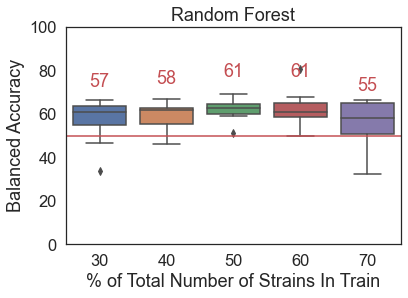

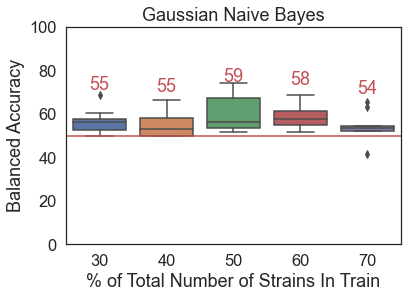

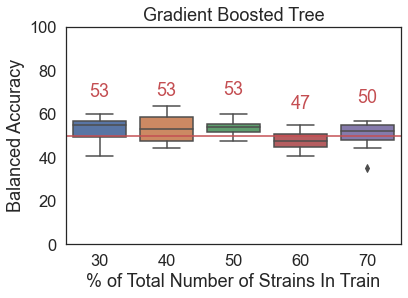

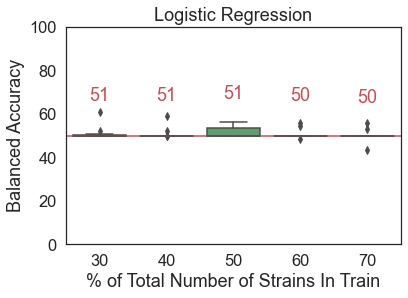

In [9]:
get_max_accuracy('amr1', th_path)
plot_leaderboard('amr1', th_path, print_acc = True)

# Test AMR features + CDC binary features (no embedding)

In [10]:
cdc_features = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/processed_cdc_data.csv', index_col = 0)
cdc_features['instance_sum'] = scaler.fit_transform(
        cdc_features['instance_sum'].values.reshape(len(cdc_features),1))

In [11]:
joined_amr_w_cdc1 = pd.merge(joined_amr, cdc_features, left_on = 'genus_species', right_index = True)
joined_amr_w_cdc1.Foe = joined_amr_w_cdc1.Foe.astype(int)

In [12]:
no_emb_path = prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/amr/AMR_w_cdc_Sep21'
w_cdc_feature_cols = feature_cols1 + cdc_features.columns.to_list()
w_cdc_cols_to_normalize = w_cdc_feature_cols[1:]

In [35]:
run_ml(joined_amr_w_cdc1, 'amr_cdc_no_emb1',feature_cols_to_use=w_cdc_feature_cols, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = no_emb_path, repeat = 10, 
       feature_cols_to_normalize=w_cdc_cols_to_normalize, sparse_cols_to_use=['antibiotic'], percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 17:28:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 17:28:28. Total run time = 0.42 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 17:28:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 17:28:29. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

Description           Model Name                  
amr_cdc_no_emb1__0.6  random_forest_classification    63.1
Name: Balanced Accuracy, dtype: float64


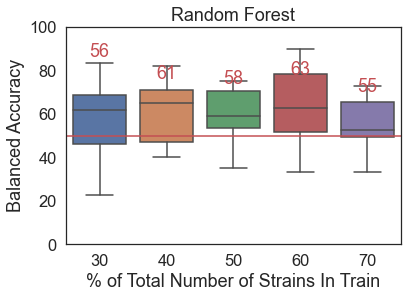

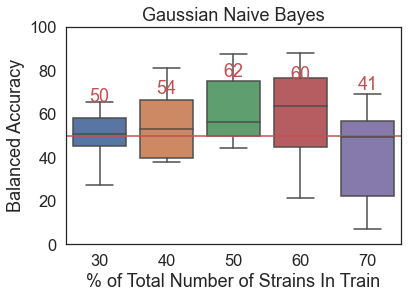

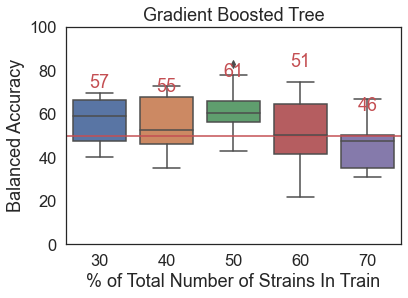

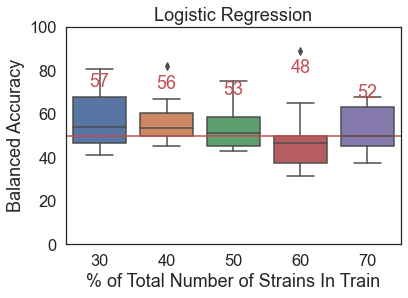

In [15]:
get_max_accuracy('amr_cdc_no_emb1', no_emb_path)
plot_leaderboard('amr_cdc_no_emb1', no_emb_path, print_acc = True)

# Test AMR features + CDC embedding (binary test features)

In [16]:
post_train_mean = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv', index_col = 0)
amr_w_cdc_emb = pd.merge(joined_amr, post_train_mean, left_on = 'genus_species', right_index = True)

In [17]:
feature_cols3 = feature_cols1 + post_train_mean.columns.tolist()
cols_to_normalize3 = feature_cols3[1:]
amr_w_cdc_emb.Foe = amr_w_cdc_emb.Foe.astype(int)

In [118]:
run_ml(amr_w_cdc_emb2, 'amr_w_cdc2',feature_cols_to_use=feature_cols3, 
       models_to_test = [logistic_classifier, gaussian_naive_bayes_classification, random_forest_classification, gradient_boosted_tree],
       output_dir = th_path, repeat = 10, 
       feature_cols_to_normalize=cols_to_normalize3, sparse_cols_to_use=['antibiotic'], percents = [0.3,0.4,0.5,0.6,0.7])


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:15:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:15:18. Total run time = 0.53 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gaussian_naive_bayes_classification at time 14:15:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.00 seconds
Testing time was: 0.01 seconds
Run finished at 14:15:19. Total run time = 0.49 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------

Description      Model Name         
amr_w_cdc2__0.7  logistic_classifier    69.7
Name: Balanced Accuracy, dtype: float64


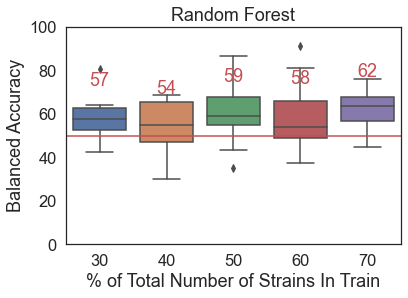

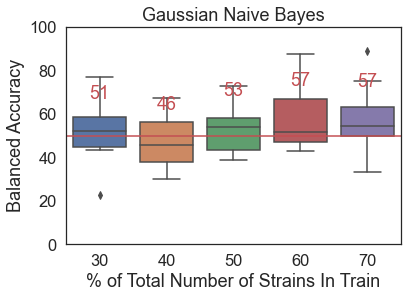

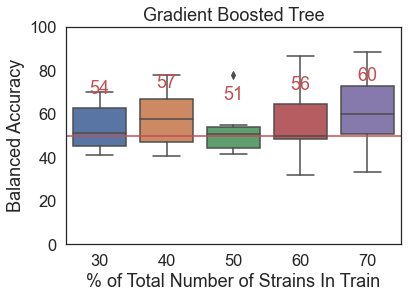

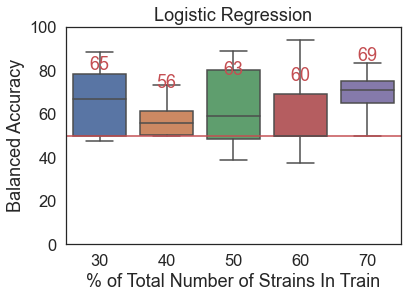

In [21]:
get_max_accuracy('amr_w_cdc2', th_path)
plot_leaderboard('amr_w_cdc2', th_path, print_acc = True)